# Лабораторная работа №3. Исследование алгоритмов классификации

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc,
                           roc_auc_score, precision_recall_curve)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('instagram_analytics_with_engagement_quality.csv')

В роли целевого класса я выбрал Engagement_Quality_Score, сгенерированный класс из 2 лабораторной работы.

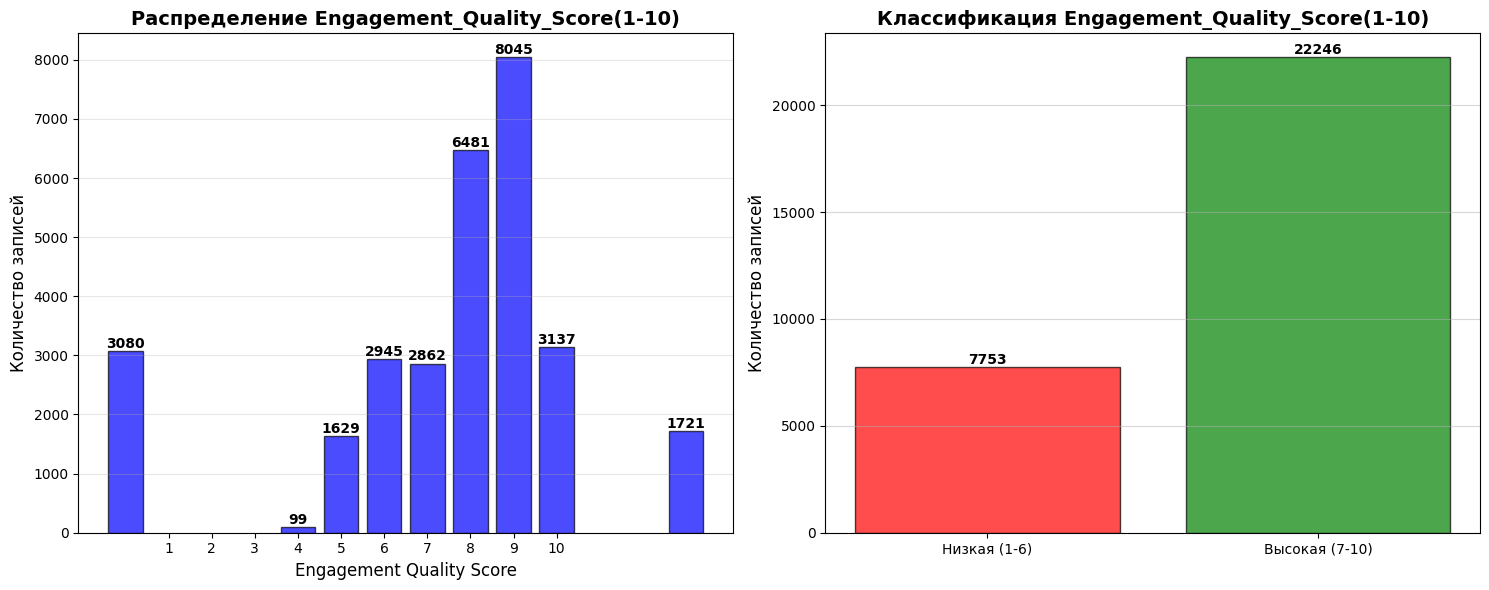

Engagement_Quality_Score
0     3080
4       99
5     1629
6     2945
7     2862
8     6481
9     8045
10    3137
13    1721
Name: count, dtype: int64
Engagement_binary
0     7753
1    22246
Name: count, dtype: int64


In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

value_counts = df['Engagement_Quality_Score'].value_counts().sort_index()

bars1 = ax1.bar(value_counts.index, value_counts.values,
               color='blue', alpha=0.7, edgecolor='black')

ax1.set_title('Распределение Engagement_Quality_Score(1-10)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Engagement Quality Score', fontsize=12)
ax1.set_ylabel('Количество записей', fontsize=12)
ax1.set_xticks(range(1, 11))
ax1.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars1, value_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

df['Engagement_binary'] = (df['Engagement_Quality_Score'] >= 7).astype(int)
binary_counts = df['Engagement_binary'].value_counts().sort_index()

binary_labels = ['Низкая (1-6)', 'Высокая (7-10)']
binary_values = [binary_counts[0], binary_counts[1]]

bars2 = ax2.bar(binary_labels, binary_values,
               color=['red', 'green'], alpha=0.7, edgecolor='black')

ax2.set_title('Классификация Engagement_Quality_Score(1-10)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Количество записей', fontsize=12)
ax2.grid(True, alpha=0.5, axis='y')

for bar, count in zip(bars2, binary_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(value_counts)
print(binary_counts)

На графике видно, что данный класс несбалансирован, а пик значений приходится на 8 и 9 баллы.
Но при этом, если разделить значения на 2 группы, то группы получаются несбалансированными.

## Оценка и сравнение результатов классификации.

In [3]:
cols_to_remove = ['post_id', 'upload_date']
for col in cols_to_remove:
    if col in df.columns:
        df = df.drop(col, axis=1)

le_media = LabelEncoder()
df['media_type'] = le_media.fit_transform(df['media_type'])

le_traffic = LabelEncoder()
df['traffic_source'] = le_traffic.fit_transform(df['traffic_source'])

for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Engagement_Quality_Score', 'Engagement_binary']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

X = df.drop(['Engagement_Quality_Score', 'Engagement_binary', 'engagement_rate'], axis=1)
y = df['Engagement_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


### Алгоритм kNN

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("Метод ближайших соседей:")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Метод ближайших соседей:
[[1240 1086]
 [ 620 6054]]
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      2326
           1       0.85      0.91      0.88      6674

    accuracy                           0.81      9000
   macro avg       0.76      0.72      0.73      9000
weighted avg       0.80      0.81      0.80      9000



### Дерево решений

In [5]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Дерево решений:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Дерево решений:
[[1400  926]
 [ 260 6414]]
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      2326
           1       0.87      0.96      0.92      6674

    accuracy                           0.87      9000
   macro avg       0.86      0.78      0.81      9000
weighted avg       0.87      0.87      0.86      9000



## Сравнение результатов двух алгоритмов

### Accuracy, Presicion, Recall, F-measure

In [6]:
y_proba_knn = knn.predict_proba(X_test)[:, 1]
y_proba_dt = dt.predict_proba(X_test)[:, 1]

metrics = {
    'Алгоритм': ['Метод ближайших соседей', 'Дерево решений'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_dt)
    ],
    'Recall': [
        recall_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_dt)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_dt)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.round(3))

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_proba_dt)

roc_knn = auc(fpr_knn, tpr_knn)
roc_dt = auc(fpr_dt, tpr_dt)

print(f"ROC метода ближайших соседей: {roc_knn:.3f}")
print(f"ROC дерево решений: {roc_dt:.3f}")

                  Алгоритм  Accuracy  Precision  Recall  F1-Score
0  Метод ближайших соседей     0.810      0.848   0.907     0.877
1           Дерево решений     0.868      0.874   0.961     0.915
ROC метода ближайших соседей: 0.770
ROC дерево решений: 0.811


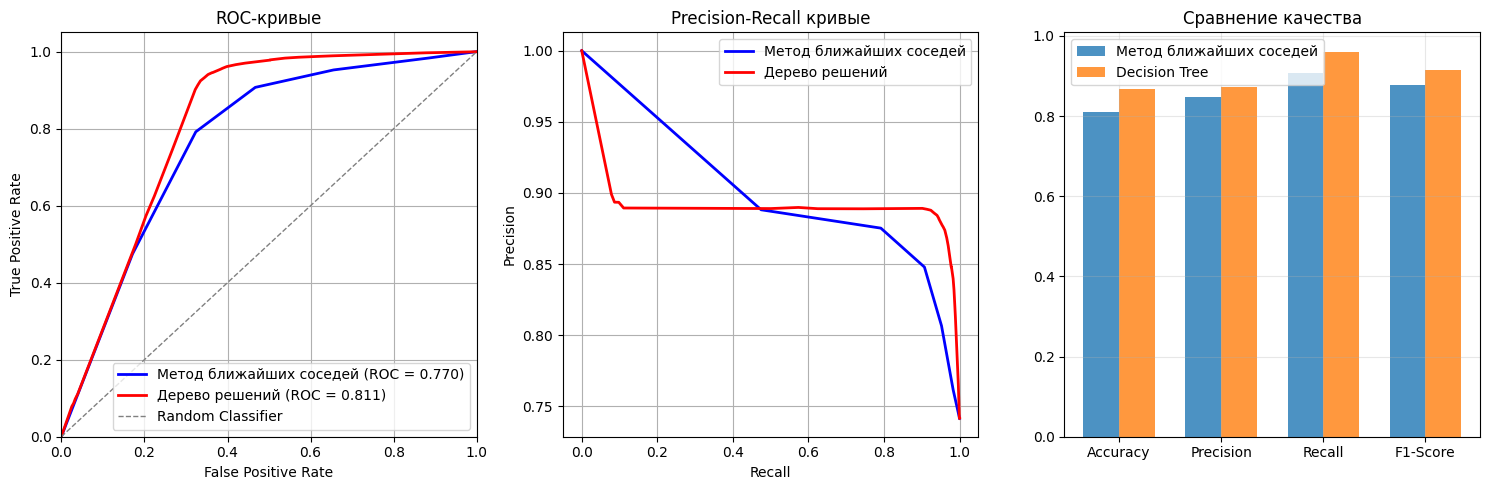

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2,
         label=f'Метод ближайших соседей (ROC = {roc_knn:.3f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2,
         label=f'Дерево решений (ROC = {roc_dt:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 3, 2)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_proba_dt)

plt.plot(recall_knn, precision_knn, color='blue', lw=2, label='Метод ближайших соседей')
plt.plot(recall_dt, precision_dt, color='red', lw=2, label='Дерево решений')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
metrics_comparison = metrics_df.drop('Алгоритм', axis=1)
x_pos = np.arange(len(metrics_comparison.columns))
width = 0.35

plt.bar(x_pos - width/2, metrics_comparison.iloc[0], width, label='Метод ближайших соседей', alpha=0.8)
plt.bar(x_pos + width/2, metrics_comparison.iloc[1], width, label='Decision Tree', alpha=0.8)

plt.title('Сравнение качества')
plt.xticks(x_pos, metrics_comparison.columns)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

На основе проведенного исследования можно сделать следующие выводы:

1. Алгоритм дерева решений показал более высокую точность (86.8%) по сравнению с методом k-ближайших соседей (81.0%).

2. По всем метрикам (Accuracy, Precision, Recall, F1-Score) дерево решений демонстрирует лучшие результаты.

3. ROC-кривые подтверждают преимущество дерева решений (AUC = 0.811) над kNN (AUC = 0.770).

4. Метод k-ближайших соседей показал более низкую производительность, что может быть связано с большим количеством признаков и отсутствием их масштабирования.

5. Для улучшения результатов kNN можно рекомендовать:
   - Масштабирование числовых признаков
   - Подбор оптимального количества соседей
   - Снижение размерности данных

В целом, для данного набора данных алгоритм дерева решений является более предпочтительным для задачи бинарной классификации качества вовлеченности.